In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun  1 17:45:41 2020

@author: mahyarfazlyab
"""

# import sys
# sys.path.append("../Python/")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.io import loadmat
import scipy.io
import os
import pickle
import matplotlib.pyplot as plt
from NeuralNetwork import NeuralNetwork



def export2matlab(file_name, net, A, B, save_model=False):
    '''
    Export pytorch fully connected network to matlab

    '''

    num_layers = int((len(net) - 1) / 2)
    dim_in = float(net[0].weight.shape[1])
    dim_out = float(net[-1].weight.shape[0])
    hidden_dims = [float(net[2 * i].weight.shape[0]) for i in range(0, num_layers)]

    # network dimensions
    dims = [dim_in] + hidden_dims + [dim_out]

    # get weights
    # weights = np.zeros((num_layers+1,))
    weights = [net[2 * i].weight.detach().numpy().astype(np.float64) for i in range(0, num_layers + 1)]

    # get biases
    # biases = np.zeros((num_layers+1,))
    biases = [net[2 * i].bias.detach().numpy().astype(np.float64).reshape(-1, 1) for i in range(0, num_layers + 1)]

    activation = str(net[1])[0:-2].lower()

    # export network data to matlab
    data = {}
    data['net'] = {'weights': weights, 'biases': biases, 'dims': dims, 'activation': activation, 'name': file_name}
    data['AMatrix'] = A
    data['BMatrix'] = B


    scipy.io.savemat(file_name + '.mat', data)





`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

trainCompleteLoop = True
# with open('xs.pkl', 'rb') as f:
#     Xtrain = pickle.load(f)
#
# with open('us.pkl', 'rb') as f:
#     Ytrain = pickle.load(f)

data = loadmat("trainDataQuad.mat")
XFull = data['X']
YFull = data['y']
# data = loadmat("quadRotorTrainData.mat")
# Xtrain = data['Xtrain']
# Ytrain = data['Ytrain']
# A = data['A']
# B = data['B']
if True:
    A = np.zeros((6, 6), dtype=np.float32)
    A[0, 3] = 1.
    A[1, 4] = 1
    A[2, 5] = 1

    B = np.zeros((6, 3), dtype=np.float32)
    B[3, 0] =  9.8
    B[4, 1] = -9.8
    B[5, 2] =  1

    C = np.zeros((6, 1), dtype=np.float32)
    C[5] = -9.8

    A = np.eye(6) + A * 0.1
    B = B * 0.1
    C = C * 0.1

else:
    A = np.array([[1, 1], [0, 1]])
    B = np.array([[0.5], [1]])
lastDim = 3
if trainCompleteLoop:
    YFull = (A @ XFull.T + B @ YFull.T + C).T
    lastDim = 6

# print(torch.linalg.norm(torch.Tensor(B)), torch.linalg.norm(torch.Tensor(A)))
# raise
# print(A)
# print(B)
# print(Xtrain.shape)
# print(Ytrain.shape)
dataSplit = 0.9
trainSize = int(dataSplit * XFull.shape[0])

trainset, testSet = torch.utils.data.random_split(torch.utils.data.TensorDataset(torch.Tensor(XFull), torch.Tensor(YFull)), [trainSize, XFull.shape[0] - trainSize])

net = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, lastDim))
numberOfLayers = (len(net) + 1) // 2
net.to(device)
train_batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True,
                                          num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=train_batch_size, num_workers=2)
epoch = 1000
net.train()
trainLosses = []
validationLosses = []
gamma = 1
def my_loss(output, target):
    prod = torch.linalg.norm(net[0].weight)
    for i in range(1, numberOfLayers):
        prod *= torch.linalg.norm(net[2 * i].weight)
    loss = torch.mean((output - target)**2) + gamma * prod
    return loss
bestStateDic = None
bestLoss = 100000
criterion = my_loss
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

lambdaVal = torch.Tensor([2]).to(device)
loaders = {"train": trainloader, "eval": testLoader}
for t in range(epoch):
    for phase in {"train", 'eval'}:
        if phase == "train":
            net.train()
        else:
            net.eval()
        tempValidationLosses = []
        for i, (X, Y) in enumerate(loaders[phase]):

            X = X.to(device)
            Y = Y.to(device)
            out = net(X)
            loss = criterion(out, Y)

            if phase == "train":
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    optimizer.zero_grad()
                    # for i in [0, 2, 4]:
                    #     net[i].weight /= torch.maximum(torch.tensor([1.]).to(device), (torch.linalg.norm(net[i].weight) / lambdaVal))
            else:
                tempValidationLosses.append(loss)
                if loss < bestLoss:
                    bestLoss = loss
                    bestStateDic = net.state_dict()
                    torch.save(bestStateDic, "tempBestStateDict.pth")
        if phase == "train":
            scheduler.step()
            gamma *= 0.9
            trainLosses.append(loss.item())
        else:
            validationLosses.append(sum(tempValidationLosses[:-1]) / (len(tempValidationLosses) - 1))
        if np.mod(t, 10) == 0:
            print("epoch:", t, "gamma", gamma)
            if phase == "train":
                with torch.no_grad():
                    prod = torch.linalg.norm(net[0].weight)
                    for i in range(1, numberOfLayers):
                        prod *= torch.linalg.norm(net[2 * i].weight)
                    print('MSE loss: ', loss.item(), ", Norm of product:", prod)
            else:
                print("validation losses average: ", validationLosses[-1])






epoch: 0 gamma 1
validation losses average:  tensor(133.2823, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 0 gamma 0.9
MSE loss:  12.071584701538086 , Norm of product: tensor(7.2511, device='cuda:0')
epoch: 10 gamma 0.34867844010000015
validation losses average:  tensor(4.3524, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 10 gamma 0.31381059609000017
MSE loss:  4.203967571258545 , Norm of product: tensor(0.0150, device='cuda:0')
epoch: 20 gamma 0.12157665459056936
validation losses average:  tensor(4.3454, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 20 gamma 0.10941898913151243
MSE loss:  4.389400959014893 , Norm of product: tensor(0.0001, device='cuda:0')
epoch: 30 gamma 0.042391158275216244
validation losses average:  tensor(4.3454, device='cuda:0', grad_fn=<DivBackward0>)
epoch: 30 gamma 0.03815204244769462
MSE loss:  3.9314870834350586 , Norm of product: tensor(0.0012, device='cuda:0')
epoch: 40 gamma 0.014780882941434608
validation losses average:  tensor(0.5372, device=

KeyboardInterrupt: 

(4.695100736618042, 4.74815182685852, 4.672193026542663, 4.703937554359436)

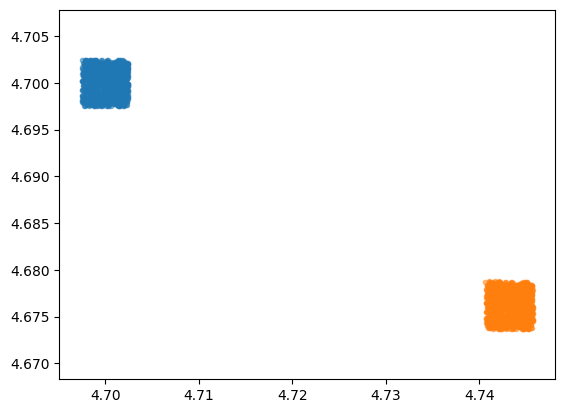

In [4]:
dim = 6
device = torch.device("cpu")
net.to(device)
lowerCoordinate = torch.Tensor([4.6975, 4.6975, 2.9975, 0.9499, -0.0001, -0.0001]).to(device)
upperCoordinate = torch.Tensor([4.7025, 4.7025 ,3.0025, 0.9501,  0.0001,  0.0001 ]).to(device)
inputData = (upperCoordinate - lowerCoordinate) * torch.rand(1000, dim, device=device) \
                                                        + lowerCoordinate
plt.scatter(inputData[:, 0], inputData[:, 1], marker='.', label='Initial', alpha=0.5)
outputData = net(inputData).detach().cpu().numpy()
plt.scatter(outputData[:, 0], outputData[:, 1], marker='.', label='Initial', alpha=0.5)
plt.axis("equal")

In [4]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

lastDim = 6
net = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, lastDim))

net.to(device)
net.load_state_dict(torch.load("tempBestStateDict.pth"))

<All keys matched successfully>

In [2]:
trainCompleteLoop = True

In [9]:
print("best loss: ", bestLoss)
net.load_state_dict(bestStateDic)
layers = []
dimensions = [net[0].weight.shape[1]]
# for i in range(len(net)):
#     if i % 2 == 0:
#         dimensions.append(net[i].weight.shape[0])
# for i in range(len(dimensions) - 1):
#     layers.append(nn.Linear(dimensions[i], dimensions[i + 1]))
#     if i < len(dimensions) - 2:
#         layers.append(nn.ReLU())
# network = nn.Sequential(*layers)
networkClass = NeuralNetwork("../randomNetwork.pth")

networkClass.Linear = net
if trainCompleteLoop:
    torch.save(networkClass.state_dict(), "../quadRotorFullLoopV1.1.pth")
else:
    torch.save(networkClass.state_dict(), "../quadRotorNormalV1.1.pth")

In [ ]:
plt.plot(trainLosses)
plt.plot([validationLoss.item() for validationLoss in validationLosses])
plt.legend(["train loss", "validation loss"])

7

(11457, 6)